In [3]:
from google.colab import drive
drive.mount('/content/drive/')

import os
os.chdir('/content/drive/My Drive/Colab Notebooks/DeepShack/train')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive/


In [1]:
%load_ext autoreload
%autoreload 2

from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import Dense, Activation, Dropout, Flatten
from tensorflow.python.keras.layers import Conv2D
from tensorflow.python.keras.layers import MaxPooling2D
from tensorflow.python.keras.applications import VGG16
from tensorflow.python.keras import regularizers
from tensorflow.python.keras.optimizers import Adam
from tensorflow.python.keras.callbacks import ModelCheckpoint
from sklearn.model_selection import train_test_split
import numpy as np
import cv2
import matplotlib.pyplot as plt
import pandas as pd
from tensorflow.python.keras.models import load_model

from image_handlers import ImageLoader, ShackCamLoader

In [4]:
new_shape = 120

In [5]:
model = Sequential([
  VGG16(weights='imagenet', include_top=False, input_shape=(new_shape, new_shape, 3)),
  Flatten(),
  Dropout(0.5),
  Dense(512, activation='relu'),
  Dropout(0.5),
  Dense(1, activation='linear')
])

58892288/58889256 [==============================] - 15s 0us/step


data/shackcam/line_mask.png
Total image samples 3878


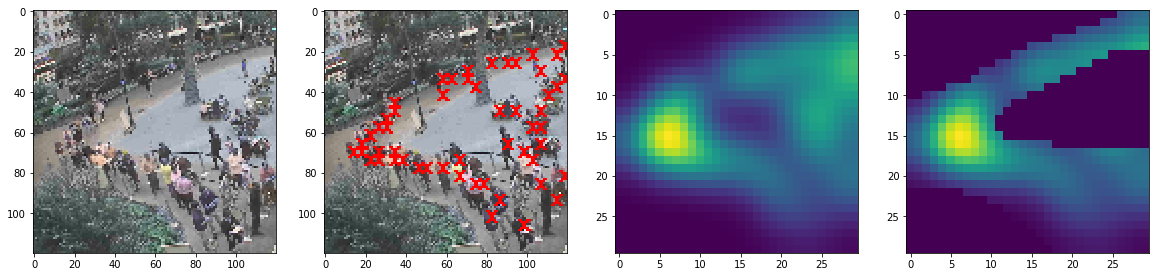

In [42]:
shackcam = ShackCamLoader(new_shape=new_shape, image_dir="data/shackcam")
shackcam.load_train_data()
shackcam.plot_image(i=500)
print('Total image samples', len(shackcam.count))

In [43]:
shape = (new_shape, new_shape)
mask = cv2.imread('data/shackcam/line_mask.png', 0) // 255
mask = cv2.resize(mask, shape)
mask = (mask == 0)

# tmp = []
# for img in shackcam.org_img:
#   img = img.copy()
#   img[mask] = 0
#   tmp.append(img)

  
# org_img = np.array(tmp)

# plt.imshow(org_img[0])

In [44]:
def mask_img(img):
    img = img.copy()
    img[mask] = 0
    return img

In [45]:
counts = pd.read_csv('data/shackcam/line_counts.csv', names=['file', 'line_count'], header=None)
counts = counts[counts.file.isin(shackcam.files)].reset_index(drop=True)
masked_img = np.array([mask_img(shackcam.data[f]['org_img']) for f in counts.file])

counts = counts.line_count.values

29

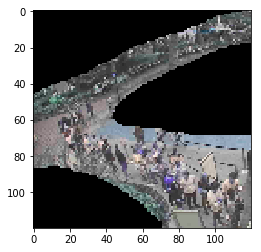

In [46]:
i = 6
plt.imshow(masked_img[i])
counts[i]

In [47]:
train_size = 0.8

x_train, x_test, y_train, y_test = train_test_split(masked_img, counts, train_size=train_size)

print('x_train', x_train.shape, 'x_test', x_test.shape)
print('y_train', y_train.shape, 'y_test', y_test.shape)

C:\Anaconda3\envs\nndl\lib\site-packages\sklearn\model_selection\_split.py:2069: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


x_train (3101, 120, 120, 3) x_test (776, 120, 120, 3)
y_train (3101,) y_test (776,)


In [51]:
adam = Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.001)
model.compile(optimizer=adam, loss='mse')
mc = ModelCheckpoint('results/vgg16_shackcam.h5', save_best_only=True)

model.fit(x_train, y_train, epochs=100, batch_size=128, 
          validation_split=0.1, verbose=1, callbacks=[mc])

scores = model.evaluate(x_test, y_test)
# print('Test loss:', scores[0])
# print('Test accuracy:', scores[1])

Train on 2790 samples, validate on 311 samples
Epoch 1/100
2790/2790 [==============================] - 11s 4ms/step - loss: 88.1402 - val_loss: 36.5489
Epoch 2/100
2790/2790 [==============================] - 10s 4ms/step - loss: 29.2210 - val_loss: 32.0646
Epoch 3/100
2790/2790 [==============================] - 10s 4ms/step - loss: 17.9793 - val_loss: 26.7600
Epoch 4/100
2790/2790 [==============================] - 10s 4ms/step - loss: 11.8631 - val_loss: 27.0788
Epoch 5/100
2790/2790 [==============================] - 10s 4ms/step - loss: 11.1616 - val_loss: 27.7127
Epoch 6/100
2790/2790 [==============================] - 10s 4ms/step - loss: 11.3145 - val_loss: 25.0427
Epoch 7/100
2790/2790 [==============================] - 10s 4ms/step - loss: 10.9399 - val_loss: 26.2607
Epoch 8/100
2790/2790 [==============================] - 10s 4ms/step - loss: 9.7266 - val_loss: 25.0479
Epoch 9/100
2790/2790 [==============================] - 10s 4ms/step - loss: 9.7335 - val_loss: 28.7436
E

Epoch 78/100
2790/2790 [==============================] - 10s 4ms/step - loss: 5.7081 - val_loss: 27.1573
Epoch 79/100
2790/2790 [==============================] - 10s 4ms/step - loss: 5.2393 - val_loss: 23.3627
Epoch 80/100
2790/2790 [==============================] - 10s 4ms/step - loss: 5.4490 - val_loss: 25.8400
Epoch 81/100
2790/2790 [==============================] - 10s 4ms/step - loss: 5.2857 - val_loss: 23.4218
Epoch 82/100
2790/2790 [==============================] - 10s 4ms/step - loss: 5.3729 - val_loss: 24.2818
Epoch 83/100
2790/2790 [==============================] - 10s 4ms/step - loss: 5.2160 - val_loss: 25.5976
Epoch 84/100
2790/2790 [==============================] - 10s 4ms/step - loss: 5.3482 - val_loss: 24.2426
Epoch 85/100
2790/2790 [==============================] - 10s 4ms/step - loss: 5.0652 - val_loss: 23.7664
Epoch 86/100
2790/2790 [==============================] - 10s 4ms/step - loss: 5.7496 - val_loss: 24.8568
Epoch 87/100
2790/2790 [======================

In [2]:
model = load_model('results/vgg16_shackcam.h5')

In [7]:
model = load_model('vgg16_shackcam.h5')

In [60]:
type(masked_img[i])

numpy.ndarray

In [61]:
np.save('test_image.npy',masked_img[i])

In [3]:
test_img = np.load('test_image.npy')

In [5]:
pred = model.predict(np.expand_dims(test_img, axis=0))[0][0]

In [6]:
pred

25.912663

pred 25.912663 truth 30


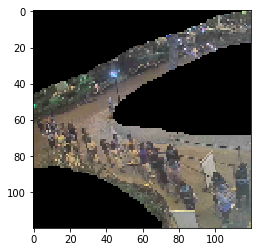

In [59]:
i = 69
plt.imshow(masked_img[i])

truth = counts[i]
pred = model.predict(np.expand_dims(masked_img[i], axis=0))[0][0]

print('pred', pred, 'truth', truth)

In [3]:
from tensorflow.python.keras.models import load_model
import numpy as np

In [4]:
model = load_model('vgg16_shackcam.h5')
test_img = np.load('test_image.npy')
pred = model.predict(np.expand_dims(test_img, axis=0))[0][0]

In [5]:
pred

25.912663